# Household Stratification by Income

This section assigns household cells to an income class based on the average earnings of the census tract the cell belongs to.

The main rationale is after Villaça, who describes the (re)structuring of the intra-urban space as mainly conditioned by the locational decisions of the upper income strata, while the popular classes do as best as they with the places that are left for them. Industries have also an important part to play, generally speaking, but they should not be that much influent in Belo Horizonte municipality, given their smaller relative presence.

In that context, we are faced with a definition problem: who are the upper strata or, simply put, who are the rich? This is an unsolved issue, but loosely inspired by Souza (2016, p. 21), we will consider as rich the group with the top 15% earnings in the 2010 Census income distribution.

- Souza, P. H. G. F. D. (2016). A desigualdade vista do topo: a concentração de renda entre os ricos no Brasil, 1926-2013.

Then, following Furtado et al (2012), we assume the same relative structure between social strata remains constant throughout the years, that is, the relative size of the rich and the poor is assumed to be constant throughout the simulation period. This assumption is to be further discussed later on, along with calibration and validation issues.

The empirical support for stratifying the land use maps from 2017 onwards with data from the 2010 census becomes weaker as the years go by. Nevertheless, this might no be too critical a issue because the literature suggests a remarkable fixity in the location choices of the higher income strata.

## 2011

In [1]:
import folium
import os
import pathlib
import re
import warnings

import contextily as cx
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Patch


%matplotlib inline
%config InlineBackend.figure_format='retina'

## Preliminaries

### Parent Folders

These should of course be adjusted to reflect the appropriate locations in your disk or wherever

In [2]:
db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)
out_folder = out_folder / 'A'

re_path = r'(BH_)(hex_\d{1,2})(_with_land_uses\.gpkg)'

for file in out_folder.iterdir():
    match = re.search(re_path, file.name)
    # If there's no search result, match is None
    if match:
        path_to_hexes = file
        idx_col = match.group(2) # .group() is one-indexed

In [3]:
def get_hexagons_with_uses(year, path, idx_col):
    if type(year) is int:
        year = str(year)
    
    # The following is just because Fiona is emmiting an annoying
    # warning message that is most likely useless (see link for
    # this issue below)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',
                                'Sequential read of iterator was interrupted')
        hex_ = gpd.read_file(path, layer=year)
    
    hex_.rename(columns={'index': idx_col},
                inplace=True)
    
    
    
    return hex_.set_index(idx_col)

https://github.com/Toblerity/Fiona/issues/986

In [4]:
hex_ = get_hexagons_with_uses(2011,
                              path_to_hexes,
                              idx_col,)

In [5]:
def _get_stats(group):
    return {'max': round(group.max()), 'min': round(group.min()),
            'mean': round(group.mean()), 'median': round(group.median()),}


def stratify_by_income(gpd, print_stats=True):
    view = gpd.loc[gpd.category=='residential']
    
    cut = pd.qcut(view.income,
                  [0, .85, 1],
                  labels=['poor', 'rich'])
    
    gpd['income_class'] = cut
    
    if print_stats:
        print(
            view.groupby(cut)['income'].apply(_get_stats).unstack()
        )

In [6]:
stratify_by_income(hex_)

          max   min  mean  median
income                           
poor     3395     0  1399    1158
rich    35101  3396  5686    5199


In [7]:
def plot_land_uses(parcels, attribute, palette, ax):
    legend_elements = []
    for cat, group in parcels.groupby(attribute):
        color = palette[cat]

        group.plot(ax=ax,
                   color=color,)

        patch_element = Patch(facecolor=color,
                              edgecolor=color,
                              label=cat,)

        legend_elements.append(patch_element)

    ax.legend(handles=legend_elements,
              bbox_to_anchor=(1, 0.01),
              loc='lower right',
              prop={'size': 4},)
    
    ax.axis('off')
    
    # Web map tiles are typically provided in Web Mercator
    # (EPSG 3857) and that's contextily default. Hence, CRS
    # needs to be adjusted to match geodata.
    cx.add_basemap(ax,
                   crs=parcels.crs.to_string(),
                   source=cx.providers.CartoDB.Positron,
                   attribution=False,)

The following maps all focus solely in residential uses that are not tagged as subnormal

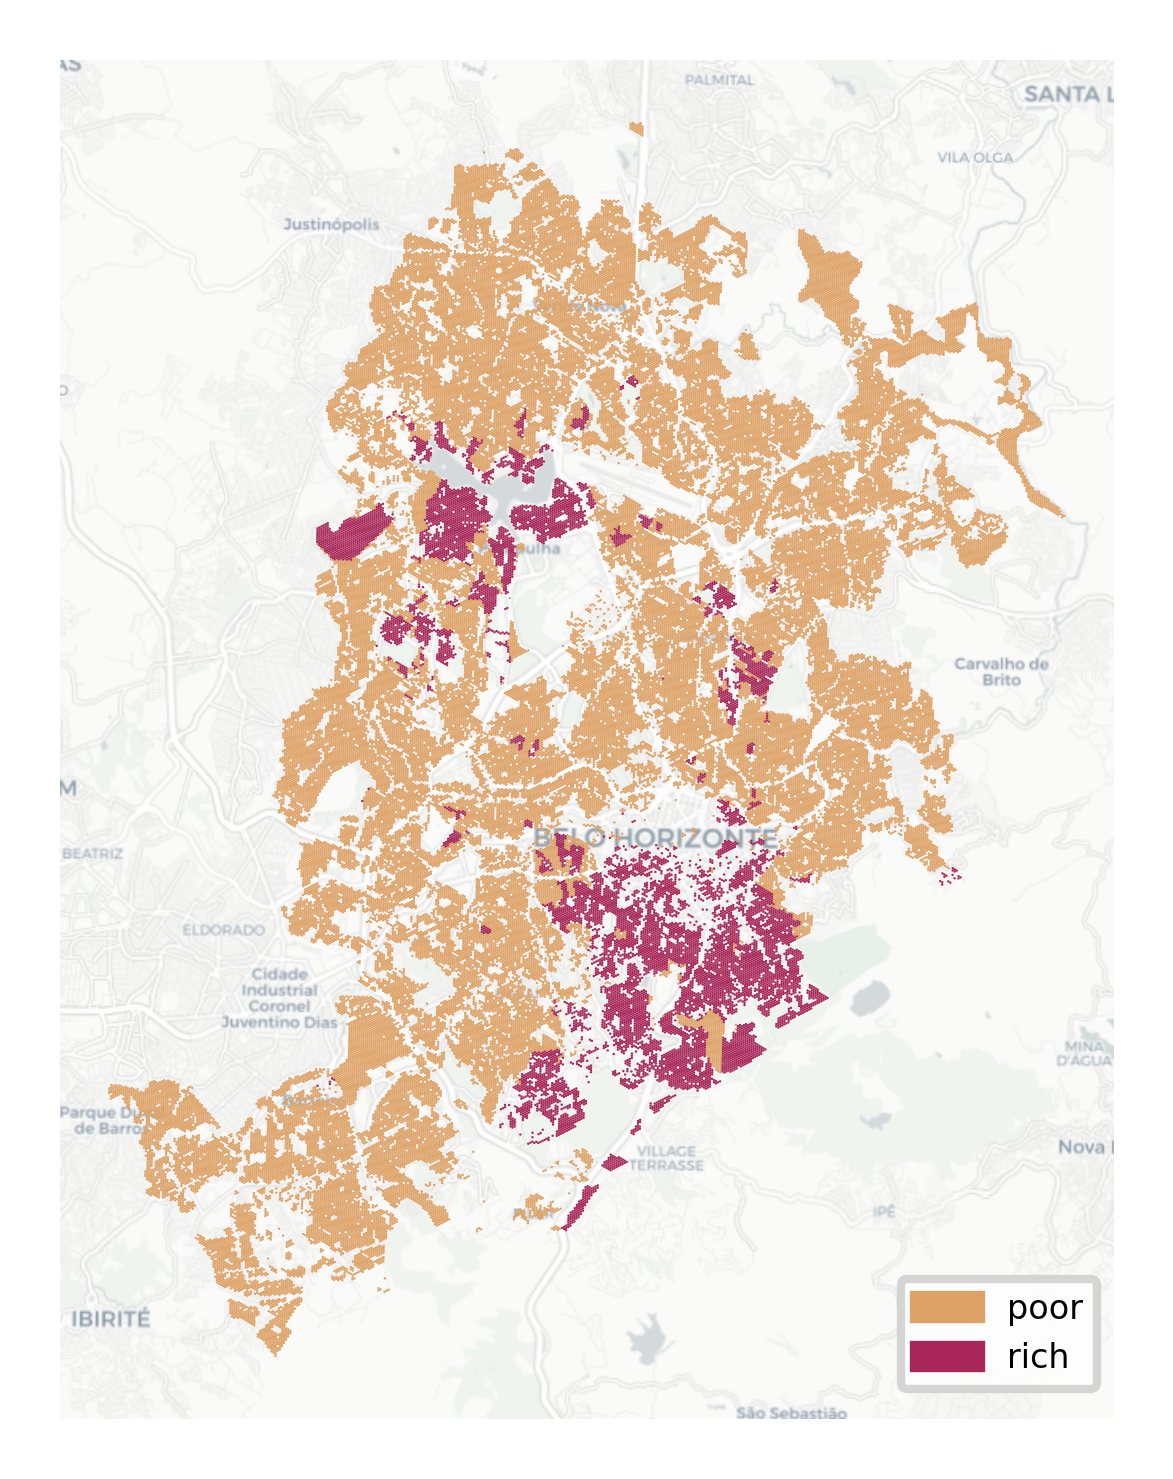

In [8]:
fig,ax = plt.subplots(dpi=300, figsize=(5,3))

palette = {'rich': '#A82758',
           'poor': '#DEA266',}
plot_land_uses(hex_, 'income_class', palette, ax)

In [9]:
def gdf_to_geopackage(gpd, year, path):
    # Income class if a Categorical dtype, which is
    # not interpreted by gpkg. Hence it is converted
    # to string before writing to file.
    gpd['income_class'] = gpd.income_class.astype(str)
    
    if type(year) is int:
        year = str(year)
    
    gpd.to_file(path,
                layer=year,
                driver='GPKG',)

In [10]:
gdf_to_geopackage(hex_, 2011, path_to_hexes)

## 2017

In [15]:
hex_ = get_hexagons_with_uses(2017,
                              path_to_hexes,
                              idx_col,)

In [16]:
stratify_by_income(hex_)

          max   min  mean  median
income                           
poor     3274     0  1361    1134
rich    35101  3274  5642    5027


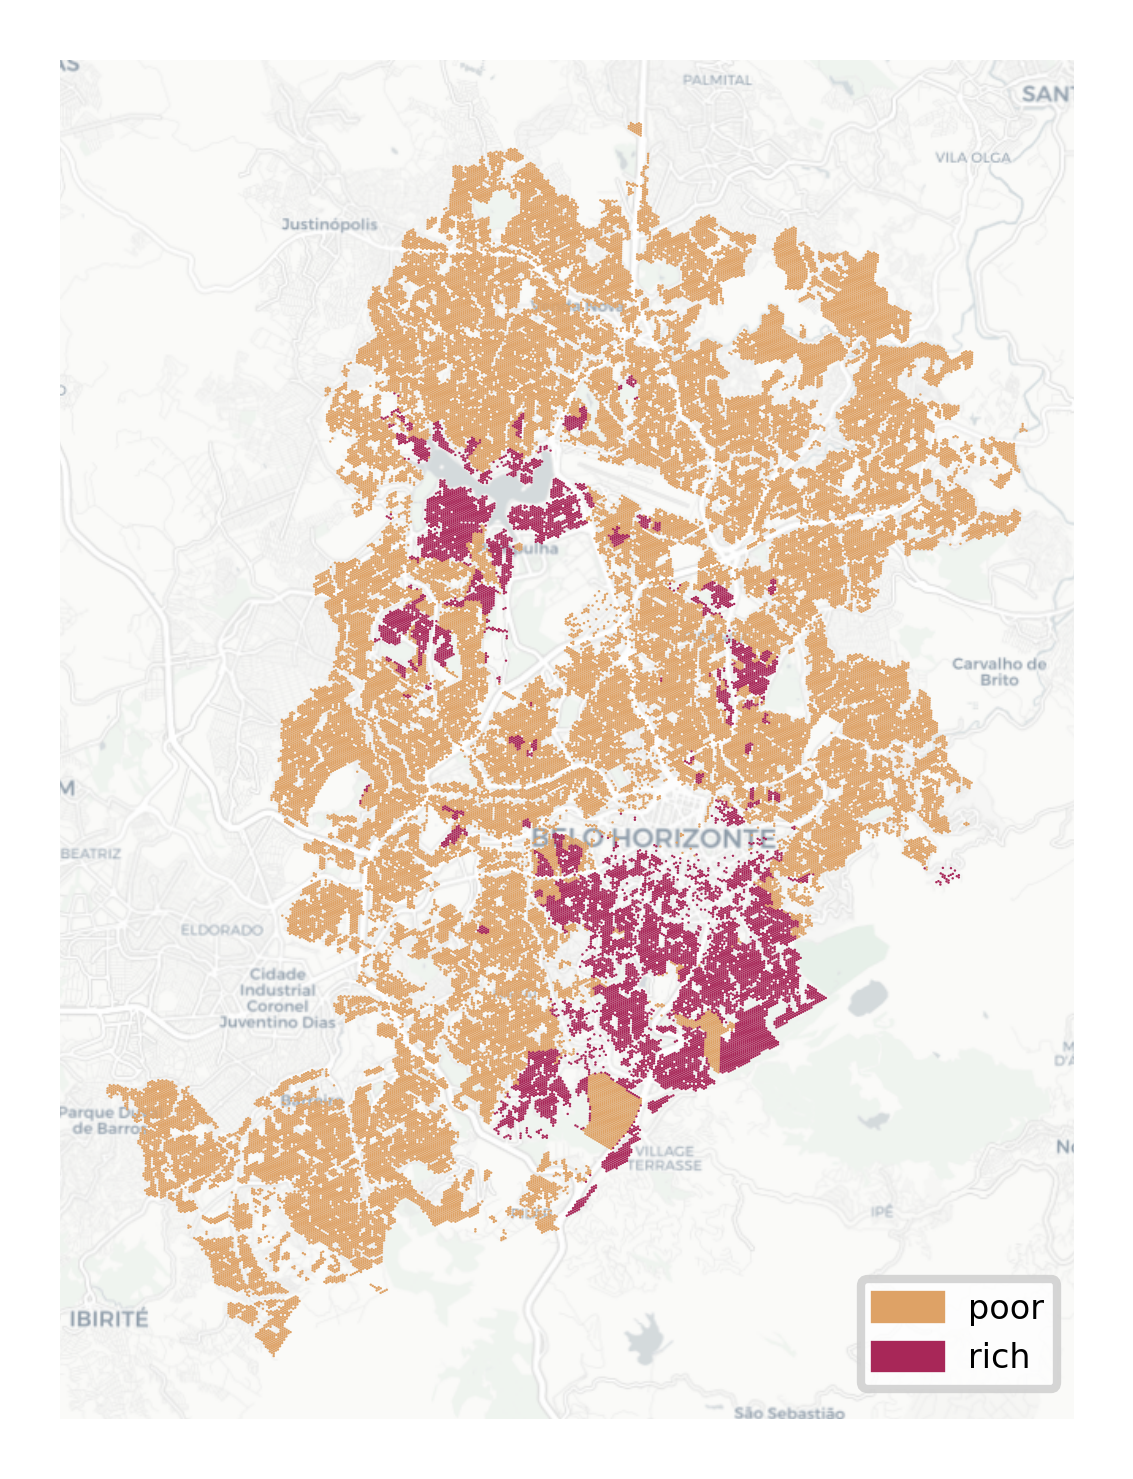

In [17]:
fig,ax = plt.subplots(dpi=300, figsize=(5,3))

palette = {'rich': '#A82758',
           'poor': '#DEA266',}
plot_land_uses(hex_, 'income_class', palette, ax)

In [18]:
gdf_to_geopackage(hex_, 2017, path_to_hexes)

## 2018

In [19]:
hex_ = get_hexagons_with_uses(2018,
                              path_to_hexes,
                              idx_col,)

In [20]:
stratify_by_income(hex_)

          max   min  mean  median
income                           
poor     3328     0  1437    1193
rich    35101  3330  5443    4883


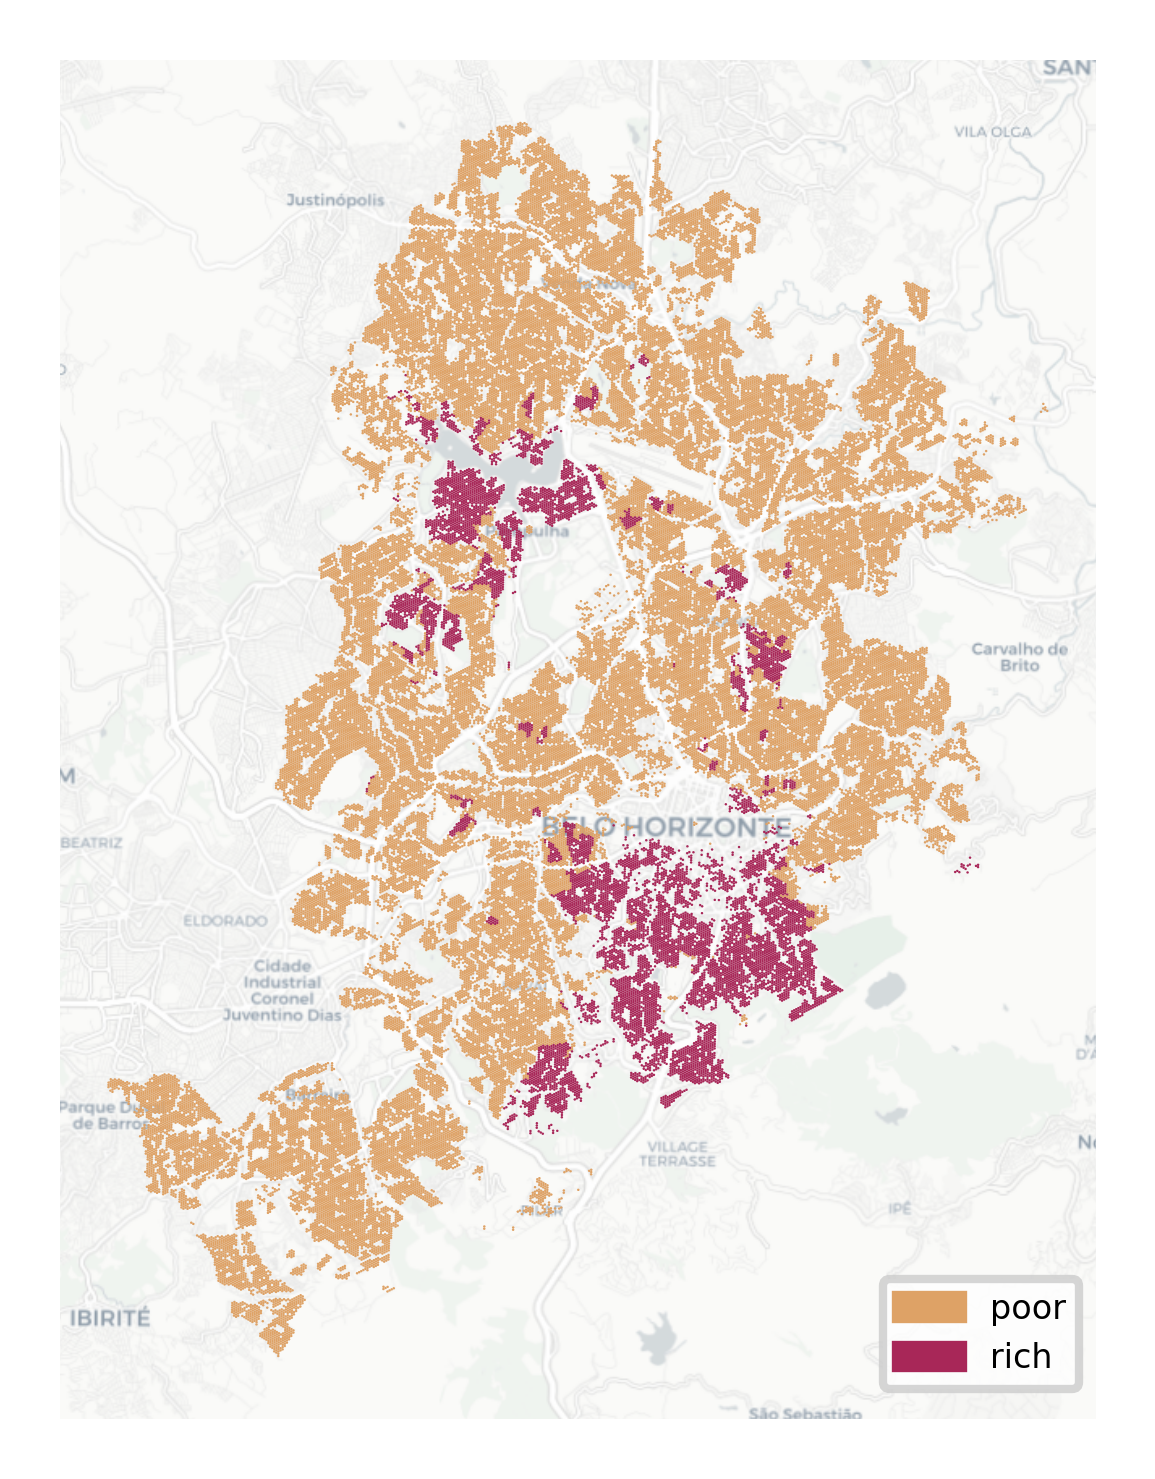

In [21]:
fig,ax = plt.subplots(dpi=300, figsize=(5,3))

palette = {'rich': '#A82758',
           'poor': '#DEA266',}
plot_land_uses(hex_, 'income_class', palette, ax)

In [22]:
gdf_to_geopackage(hex_, 2018, path_to_hexes)

## 2020

In [23]:
hex_ = get_hexagons_with_uses(2020,
                              path_to_hexes,
                              idx_col,)

In [24]:
stratify_by_income(hex_)

          max   min  mean  median
income                           
poor     3365     0  1446    1197
rich    35101  3366  5506    4932


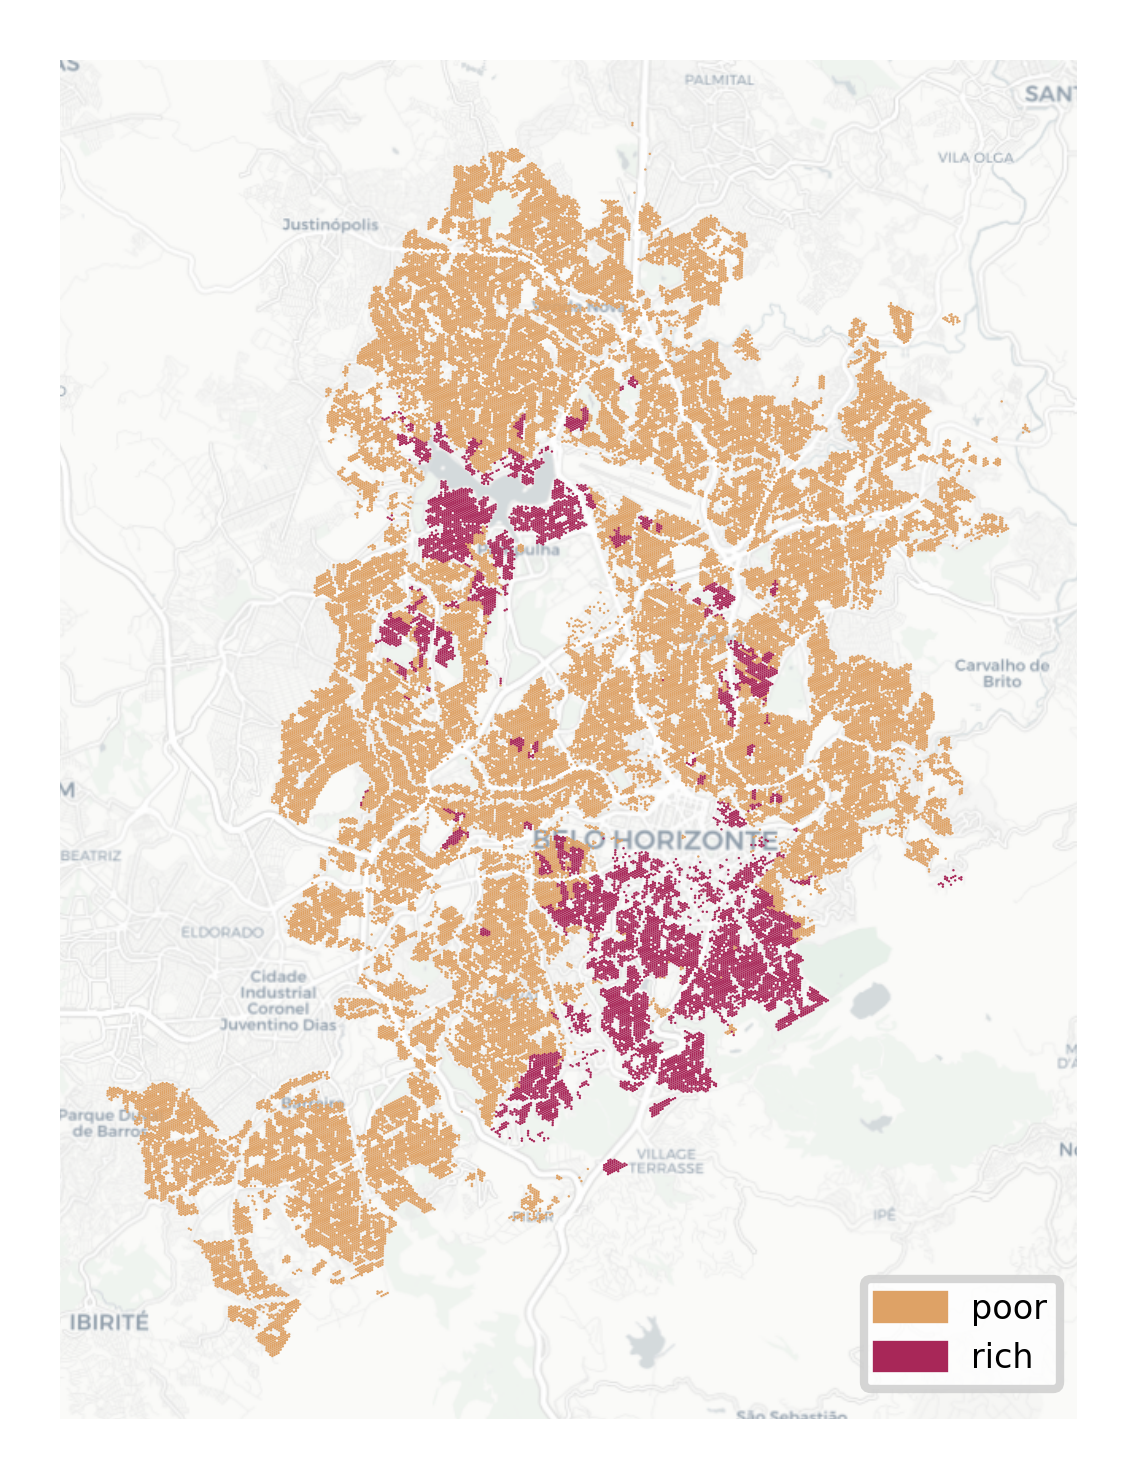

In [25]:
fig,ax = plt.subplots(dpi=300, figsize=(5,3))

palette = {'rich': '#A82758',
           'poor': '#DEA266',}
plot_land_uses(hex_, 'income_class', palette, ax)

In [26]:
gdf_to_geopackage(hex_, 2020, path_to_hexes)